In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
from torch_geometric.datasets import TUDataset
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import random

# Imposta i seed per la riproducibilità
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [2]:
def create_synthetic_ppi_network(n_proteins=1000, n_interactions=3000):
    """
    Crea una rete PPI sintetica con caratteristiche biologiche realistiche
    """
    # Genera un grafo random con proprietà biologiche
    G = nx.barabasi_albert_graph(n_proteins, 3)  # Grafo scale-free tipico delle reti biologiche
    
    # Aggiungi edge aggiuntivi per raggiungere il numero desiderato
    edges_to_add = n_interactions - G.number_of_edges()
    if edges_to_add > 0:
        for _ in range(edges_to_add):
            u, v = random.sample(range(n_proteins), 2)
            if not G.has_edge(u, v):
                G.add_edge(u, v)
    
    # Crea features per le proteine (simulano proprietà biochimiche)
    protein_features = {}
    for node in G.nodes():
        # Features che potrebbero rappresentare:
        # - Peso molecolare (normalizzato)
        # - Punto isoelettrico (normalizzato)
        # - Numero di domini proteici
        # - Idrofobicità media
        # - Lunghezza della sequenza (normalizzata)
        features = [
            np.random.normal(50, 15),  # Peso molecolare simulato
            np.random.normal(7, 2),    # pI simulato
            np.random.randint(1, 10),  # Numero domini
            np.random.uniform(-2, 2),  # Idrofobicità
            np.random.normal(300, 100) # Lunghezza sequenza
        ]
        protein_features[node] = np.array(features)
    
    # Crea labels biologicamente significative
    # Simula 4 classi funzionali: Enzimi, Fattori di trascrizione, 
    # Proteine strutturali, Proteine di trasporto
    labels = {}
    for node in G.nodes():
        # Le proteine con molte connessioni tendono ad essere hub (enzimi/fattori di trascrizione)
        degree = G.degree(node)
        if degree > 8:
            labels[node] = random.choice([0, 1])  # Enzimi o Fattori di trascrizione
        elif degree > 4:
            labels[node] = 2  # Proteine strutturali
        else:
            labels[node] = 3  # Proteine di trasporto
    
    return G, protein_features, labels

# Crea la rete
G, protein_features, protein_labels = create_synthetic_ppi_network()
print(f"Rete creata con {G.number_of_nodes()} proteine e {G.number_of_edges()} interazioni")
print(f"Distribuzione delle classi: {pd.Series(protein_labels.values()).value_counts().to_dict()}")

Rete creata con 1000 proteine e 3000 interazioni
Distribuzione delle classi: {3: 594, 2: 267, 1: 80, 0: 59}


In [17]:
# Funzione per la visualizzazione
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Funzione per visualizzare grafi NX o tensori PyTorch
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        #nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
        #                 node_color=color, cmap="Set2")
        nx.draw_networkx(h, pos=nx.spring_layout(h, k=1/np.sqrt(h.number_of_nodes()), iterations=100), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [9]:
def create_synthetic_ppi_network(n_proteins=1000, n_interactions=3000):
    """
    Crea una rete PPI sintetica con caratteristiche biologiche realistiche
    """
    # Genera un grafo random con proprietà biologiche
    G = nx.barabasi_albert_graph(n_proteins, 3)  # Grafo scale-free tipico delle reti biologiche
    
    # Aggiungi edge aggiuntivi per raggiungere il numero desiderato
    edges_to_add = n_interactions - G.number_of_edges()
    if edges_to_add > 0:
        for _ in range(edges_to_add):
            u, v = random.sample(range(n_proteins), 2)
            if not G.has_edge(u, v):
                G.add_edge(u, v)
    
    # Crea features per le proteine (simulano proprietà biochimiche)
    protein_features = {}
    for node in G.nodes():
        # Features che potrebbero rappresentare:
        # - Peso molecolare (normalizzato)
        # - Punto isoelettrico (normalizzato)
        # - Numero di domini proteici
        # - Idrofobicità media
        # - Lunghezza della sequenza (normalizzata)
        features = [
            np.random.normal(50, 15),  # Peso molecolare simulato
            np.random.normal(7, 2),    # pI simulato
            np.random.randint(1, 10),  # Numero domini
            np.random.uniform(-2, 2),  # Idrofobicità
            np.random.normal(300, 100) # Lunghezza sequenza
        ]
        protein_features[node] = np.array(features)
    
    # Crea labels biologicamente significative
    # Simula 4 classi funzionali: Enzimi, Fattori di trascrizione, 
    # Proteine strutturali, Proteine di trasporto
    labels = {}
    for node in G.nodes():
        # Le proteine con molte connessioni tendono ad essere hub (enzimi/fattori di trascrizione)
        degree = G.degree(node)
        if degree > 8:
            labels[node] = random.choice([0, 1])  # Enzimi o Fattori di trascrizione
        elif degree > 4:
            labels[node] = 2  # Proteine strutturali
        else:
            labels[node] = 3  # Proteine di trasporto
    
    return G, protein_features, labels



In [10]:
def networkx_to_pyg(G, features_dict, labels_dict):
    """
    Converte un grafo NetworkX in formato PyTorch Geometric
    """
    # Crea mapping dei nodi
    node_mapping = {node: i for i, node in enumerate(G.nodes())}
    
    # Crea edge_index
    edge_list = [(node_mapping[u], node_mapping[v]) for u, v in G.edges()]
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    # Aggiungi edges bidirezionali (se non già presenti)
    edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
    
    # Crea feature matrix
    features_list = [features_dict[node] for node in sorted(G.nodes())]
    x = torch.tensor(features_list, dtype=torch.float)
    
    # Crea labels
    labels_list = [labels_dict[node] for node in sorted(G.nodes())]
    y = torch.tensor(labels_list, dtype=torch.long)
    
    # Crea oggetto Data
    data = Data(x=x, edge_index=edge_index, y=y)
    
    return data

# Converti la rete
data = networkx_to_pyg(G, protein_features, protein_labels)
print(f"Dati PyG creati:")
print(f"- Numero nodi: {data.num_nodes}")
print(f"- Numero edges: {data.num_edges/2}")
print(f"- Dimensione features: {data.num_node_features}")
print(f"- Numero classi: {len(torch.unique(data.y))}")

Dati PyG creati:
- Numero nodi: 1000
- Numero edges: 3000.0
- Dimensione features: 5
- Numero classi: 4


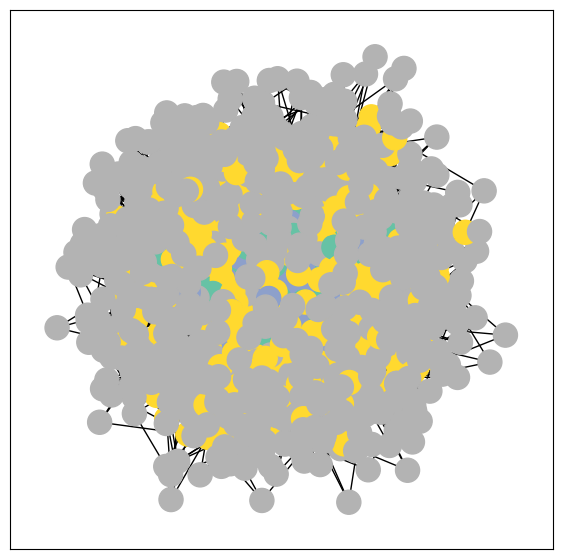

In [18]:
# Visualizziamo la rete
visualize(G, color=data.y)

In [19]:
## Preparazione dei Dati per il Training

def create_masks(num_nodes, train_ratio=0.6, val_ratio=0.2):
    """Crea maschere per train/validation/test"""
    indices = torch.randperm(num_nodes)
    
    train_size = int(num_nodes * train_ratio)
    val_size = int(num_nodes * val_ratio)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size + val_size]] = True
    test_mask[indices[train_size + val_size:]] = True
    
    return train_mask, val_mask, test_mask

# Crea le maschere
train_mask, val_mask, test_mask = create_masks(data.num_nodes)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Dataset split:")
print(f"- Training: {train_mask.sum().item()} nodi")
print(f"- Validation: {val_mask.sum().item()} nodi")
print(f"- Test: {test_mask.sum().item()} nodi")

Dataset split:
- Training: 600 nodi
- Validation: 200 nodi
- Test: 200 nodi


In [32]:
##  Implementazione del Modello GraphSAGE

# Creare una classe GraphSAGE che ha un numerdi layer variabile (almeno 2) + un layer che codifica la classificaizone. 
# Il numero di hidden layer è settato come parametro per il layer 1, al successivo layer viene dimezzato
# L'ultimo layer è sempre quello di classificazione.
# es se ho 2 layer e come hidden layer 128 dal primo layer passo dal numero di variaibli dei nodi a 128, al seocndo da 128 a 64


class GraphSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.5):
        super(GraphSAGE, self).__init__()

        self.num_layers = num_layers
        self.dropout = dropout
        """IL CODICE QUI"""        

        
    def forward(self, x, edge_index, batch=None):
        # Forward pass attraverso i layer SAGE
        # CODICE QUI
        
        # Ultimo layer senza attivazione
        x = self.convs[-1](x, edge_index)
        
        return F.log_softmax(x, dim=1)
    
    def embed(self, x, edge_index):
        """Restituisce gli embeddings senza classificazione"""
         # CODICE QUI
        
        # Ultimo layer senza attivazione
        
        return x

# Crea il modello
model = GraphSAGE(
    input_dim=data.num_node_features,
    hidden_dim=32,
    output_dim=len(torch.unique(data.y)),
    num_layers=5,
    dropout=0.3
)

print(f"Modello creato con {sum(p.numel() for p in model.parameters())} parametri")


Modello creato con 7108 parametri


In [33]:
## Training del Modello

# Addestrare il modello, stampare la loss ogni 50 iterazioni calcolare l'accuratezza sul validation set.

def train_model(model, data, num_epochs=2000, lr=0.01, weight_decay=5e-4):
    """Training loop per GraphSAGE"""
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.NLLLoss()
    
    train_losses = []
    val_accuracies = []
    
    model.train()
    
    for epoch in range(num_epochs):
      """ CODICE QUI """
    
    return train_losses, val_accuracies

# Training
print("Inizio training...")
train_losses, val_accuracies = train_model(model, data, num_epochs=3000)
print("Training completato!")

Inizio training...
Epoch 000, Loss: 1.6531, Val Acc: 0.3000
Epoch 050, Loss: 0.7295, Val Acc: 0.5750
Epoch 100, Loss: 0.6381, Val Acc: 0.6300
Epoch 150, Loss: 0.5763, Val Acc: 0.5500
Epoch 200, Loss: 0.4843, Val Acc: 0.5600
Epoch 250, Loss: 0.4538, Val Acc: 0.5750
Epoch 300, Loss: 0.4365, Val Acc: 0.6400
Epoch 350, Loss: 0.4104, Val Acc: 0.6300
Epoch 400, Loss: 0.3795, Val Acc: 0.6400
Epoch 450, Loss: 0.3595, Val Acc: 0.5650
Epoch 500, Loss: 0.3287, Val Acc: 0.6250
Epoch 550, Loss: 0.3542, Val Acc: 0.6250
Epoch 600, Loss: 0.3215, Val Acc: 0.6100
Epoch 650, Loss: 0.3266, Val Acc: 0.6700
Epoch 700, Loss: 0.3736, Val Acc: 0.5450
Epoch 750, Loss: 0.3200, Val Acc: 0.5750
Epoch 800, Loss: 0.2978, Val Acc: 0.5900
Epoch 850, Loss: 0.3215, Val Acc: 0.6650
Epoch 900, Loss: 0.3172, Val Acc: 0.5400
Epoch 950, Loss: 0.2878, Val Acc: 0.6300
Epoch 1000, Loss: 0.3185, Val Acc: 0.6550
Epoch 1050, Loss: 0.2699, Val Acc: 0.6000
Epoch 1100, Loss: 0.3370, Val Acc: 0.6100
Epoch 1150, Loss: 0.2577, Val Acc: 

In [34]:
##  Valutazione del Modello

def evaluate_model(model, data):
    """Valuta il modello sul test set"""
    model.eval()
    
    with torch.no_grad():
        # Predizioni
     
              """ CODICE QUI """

        
        # Accuratezza per ogni split
      """ CODICE QUI """
       
        # Classification report per test set
      """ CODICE QUI """
     
        
        
        class_names = ['Enzimi', 'Fattori Trascrizione', 'Proteine Strutturali', 'Proteine Trasporto']
        report = classification_report(y_true, y_pred, target_names=class_names)
        
        return {
            'train_acc': train_acc.item(),
            'val_acc': val_acc.item(),
            'test_acc': test_acc.item(),
            'classification_report': report,
            'predictions': pred.cpu().numpy()
        }

# Valutazione
results = evaluate_model(model, data)

print(f"\n=== RISULTATI FINALI ===")
print(f"Training Accuracy: {results['train_acc']:.4f}")
print(f"Validation Accuracy: {results['val_acc']:.4f}")
print(f"Test Accuracy: {results['test_acc']:.4f}")
print(f"\nClassification Report:\n{results['classification_report']}")



=== RISULTATI FINALI ===
Training Accuracy: 0.8600
Validation Accuracy: 0.6200
Test Accuracy: 0.6300

Classification Report:
                      precision    recall  f1-score   support

              Enzimi       0.33      0.20      0.25        10
Fattori Trascrizione       0.50      0.05      0.08        22
Proteine Strutturali       0.30      0.36      0.33        44
  Proteine Trasporto       0.77      0.86      0.81       124

            accuracy                           0.63       200
           macro avg       0.48      0.37      0.37       200
        weighted avg       0.62      0.63      0.60       200



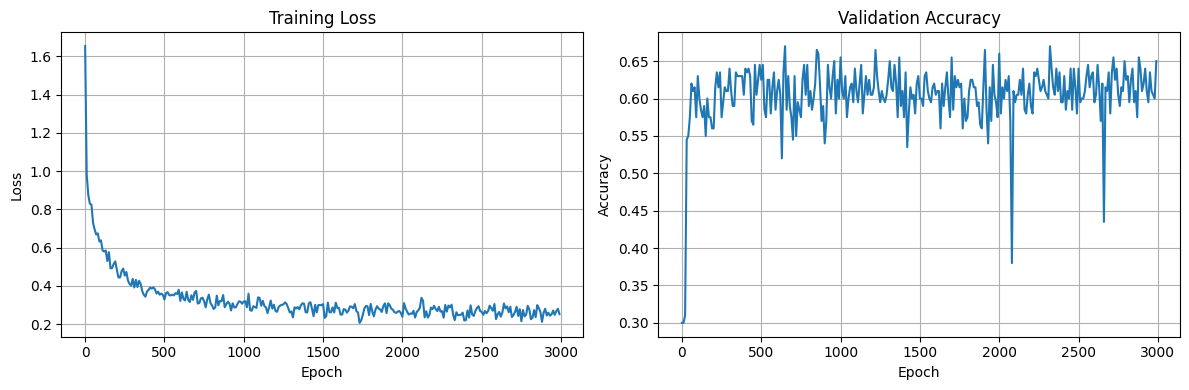

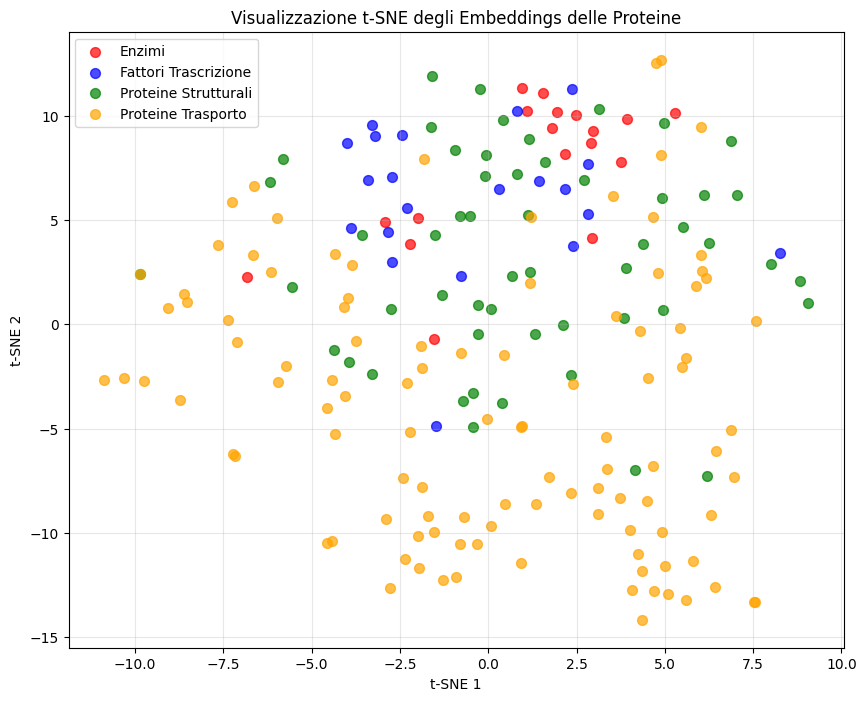

In [35]:
## Visualizzazione e Analisi

def plot_training_curves(train_losses, val_accuracies):
    """Plotta le curve di training"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    epochs = range(0, len(train_losses) * 10, 10)
    ax1.plot(epochs, train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)
    
    # Validation Accuracy
    ax2.plot(epochs, val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_embeddings(model, data, sample_size=200):
    """Visualizza gli embeddings in 2D usando t-SNE"""
    from sklearn.manifold import TSNE
    
    model.eval()
    with torch.no_grad():
        embeddings = model.embed(data.x, data.edge_index)
    
    # Campiona alcuni nodi per la visualizzazione
    indices = torch.randperm(data.num_nodes)[:sample_size]
    embed_subset = embeddings[indices].cpu().numpy()
    labels_subset = data.y[indices].cpu().numpy()
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embed_2d = tsne.fit_transform(embed_subset)
    
    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['red', 'blue', 'green', 'orange']
    class_names = ['Enzimi', 'Fattori Trascrizione', 'Proteine Strutturali', 'Proteine Trasporto']
    
    for i, (color, name) in enumerate(zip(colors, class_names)):
        mask = labels_subset == i
        plt.scatter(embed_2d[mask, 0], embed_2d[mask, 1], 
                   c=color, label=name, alpha=0.7, s=50)
    
    plt.legend()
    plt.title('Visualizzazione t-SNE degli Embeddings delle Proteine')
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
    plt.grid(True, alpha=0.3)
    plt.show()

# Visualizzazioni
plot_training_curves(train_losses, val_accuracies)
visualize_embeddings(model, data)